In [1]:
import torch
import torchvision
import torchbearer

import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

import matplotlib.pyplot as plt
import numpy as np
import sklearn.metrics
import itertools

import os
import datetime

import glob
import matplotlib.pyplot as plt
import numpy as np

import livelossplot

import cure_dataset
import cure_models
import cure_utils

In [2]:
load_raw = torchvision.transforms.Compose([
    torchvision.transforms.Resize((32,32)),
    torchvision.transforms.ToTensor()])

In [ ]:
# load real and unreal challenge free images 
testdataset = cure_dataset.CURETSRDatasetCached('../data', 'Test', '*', '06', '*', transform=load_raw)
traindataset = cure_dataset.CURETSRDatasetCached('../data', 'Train', '*', '06', '*', transform=load_raw)

trainloader = torch.utils.data.DataLoader(traindataset, batch_size=256,
                                          shuffle=False, num_workers=0)
testloader = torch.utils.data.DataLoader(testdataset, batch_size=512,
                                          shuffle=False, num_workers=0)


In [3]:
challenge_labels_short = {}
challenge_labels = {}
challenge_labels['00'] = 'No challenge' 
challenge_labels['01'] = 'Decolorization' 
challenge_labels['02'] = 'Lens blur' 
challenge_labels['03'] = 'Codec error' 
challenge_labels['04'] = 'Darkening' 
challenge_labels['05'] = 'Dirty lens' 
challenge_labels['06'] = 'Exposure' 
challenge_labels['07'] = 'Gaussian blur' 
challenge_labels['08'] = 'Noise' 
challenge_labels['09'] = 'Rain' 
challenge_labels['10'] = 'Shadow' 
challenge_labels['11'] = 'Snow' 
challenge_labels['12'] = 'Haze'

challenge_labels_short['00'] = 'Nochallenge' 
challenge_labels_short['01'] = 'Decolorization' 
challenge_labels_short['02'] = 'Lens blur' 
challenge_labels_short['03'] = 'CodecError' 
challenge_labels_short['04'] = 'Darkening' 
challenge_labels_short['05'] = 'DirtyLens' 
challenge_labels_short['06'] = 'Exposure' 
challenge_labels_short['07'] = 'GaussianBlur' 
challenge_labels_short['08'] = 'Noise' 
challenge_labels_short['09'] = 'Rain' 
challenge_labels_short['10'] = 'Shadow' 
challenge_labels_short['11'] = 'Snow' 
challenge_labels_short['12'] = 'Haze'

In [ ]:
%%time
for challenge in challenge_labels_short.keys():
    print('Running challenge: ', challenge_labels[challenge])
    # Construct a dataset
    testdataset = cure_dataset.CURETSRDatasetCached('../data', 'Test', '*', challenge, '*', transform=load_raw)
    traindataset = cure_dataset.CURETSRDatasetCached('../data', 'Train', '*', challenge, '*', transform=load_raw)
    traindataset_1_3 = cure_dataset.CURETSRDatasetCached('../data', 'Train', '*', challenge, '0[1-3]', transform=load_raw)
    
    trainloader = torch.utils.data.DataLoader(traindataset, batch_size=256,
                                          shuffle=False, num_workers=0)
    trainloader_1_3 = torch.utils.data.DataLoader(traindataset_1_3, batch_size=256,
                                          shuffle=False, num_workers=0)
    
    testloader = torch.utils.data.DataLoader(testdataset, batch_size=512,
                                          shuffle=False, num_workers=0)
    
    # construct the model - all data
    model = cure_models.ShallowNetwork().cuda()
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=.001, amsgrad=True)
    
    checkpoint_name = os.path.join('alldata_checkpoints', 'shallowCNN_' + challenge_labels_short[challenge] + '_all.{epoch:02d}-{val_acc:.3f}.pt')
    callbacks = [torchbearer.callbacks.checkpointers.Best(checkpoint_name, monitor='val_acc', mode='max')]
    trial = torchbearer.Trial(model, optimizer, criterion, ['acc', 'loss'], callbacks=callbacks, verbose=2).with_generators(
        train_generator=trainloader,
        val_generator=testloader
    ).cuda()
    
    trial.run(epochs=75)
    
    # construct the model - only the first three levels
    # skip this on the challenge free
    if challenge == '00':
        continue
    
    model = cure_models.ShallowNetwork().cuda()
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=.001, amsgrad=True)
    
    checkpoint_name = os.path.join('alldata_checkpoints', 'shallowCNN_' + challenge_labels_short[challenge] + '_1_3.{epoch:02d}-{val_acc:.3f}.pt')
    callbacks = [torchbearer.callbacks.checkpointers.Best(checkpoint_name, monitor='val_acc', mode='max')]
    trial = torchbearer.Trial(model, optimizer, criterion, ['acc', 'loss'], callbacks=callbacks, verbose=2).with_generators(
        train_generator=trainloader_1_3,
        val_generator=testloader
    ).cuda()
    
    trial.run(epochs=75)

# Train gating network on all noise classes

In [10]:
%%time
# real and unreal, all noise types, all levels
testdataset_paths = cure_dataset.CURETSRDataset('../data', 'Test', '*', '*', '*', transform=load_raw).paths
traindataset_paths = cure_dataset.CURETSRDataset('../data', 'Train', '*', '*', '*', transform=load_raw).paths

traindataset = cure_dataset.CURETSRDataset_Noise_AllLabels_Cached('','','','','', fromPaths=traindataset_paths, transform=load_raw)
testdataset = cure_dataset.CURETSRDataset_Noise_AllLabels_Cached('','','','','', fromPaths=testdataset_paths, transform=load_raw)


trainloader = torch.utils.data.DataLoader(traindataset, batch_size=256,
                                          shuffle=False, num_workers=0)
testloader = torch.utils.data.DataLoader(testdataset, batch_size=512,
                                          shuffle=False, num_workers=0)


CPU times: user 8min 31s, sys: 44.6 s, total: 9min 16s
Wall time: 9min 15s


In [22]:
importlib.reload(cure_models)

<module 'cure_models' from '/home/ubuntu/project/cure_models.py'>

In [14]:
# construct the model - all data
model = cure_models.GatingNetwork_all_classes().cuda()
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=.001, amsgrad=True)

checkpoint_name = os.path.join('alldata_checkpoints', 'shallowCNN_gating_network_all_data.{epoch:02d}-{val_acc:.3f}.pt')
callbacks = [torchbearer.callbacks.LiveLossPlot(), torchbearer.callbacks.checkpointers.Best(checkpoint_name, monitor='val_acc', mode='max')]
trial = torchbearer.Trial(model, optimizer, criterion, ['acc', 'loss'], callbacks=callbacks, verbose=2).with_generators(
    train_generator=trainloader,
    val_generator=testloader
).cuda()

In [17]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=.01, amsgrad=True)

checkpoint_name = os.path.join('alldata_checkpoints', 'shallowCNN_gating_network_all_data.{epoch:02d}-{val_acc:.3f}.pt')
callbacks = [torchbearer.callbacks.LiveLossPlot(), torchbearer.callbacks.checkpointers.Best(checkpoint_name, monitor='val_acc', mode='max')]
trial = torchbearer.Trial(model, optimizer, criterion, ['acc', 'loss'], callbacks=callbacks, verbose=2).with_generators(
    train_generator=trainloader,
    val_generator=testloader
).cuda()

In [ ]:
trial.run(epochs=75)

In [23]:
# construct the model - all data
model = cure_models.DeeperCNNRGB_GatingNetwork().cuda()
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=.001, amsgrad=True)

checkpoint_name = os.path.join('alldata_checkpoints', 'deeperCNN_gating_network_all_data.{epoch:02d}-{val_acc:.3f}.pt')
callbacks = [torchbearer.callbacks.LiveLossPlot(), torchbearer.callbacks.checkpointers.Best(checkpoint_name, monitor='val_acc', mode='max')]
trial = torchbearer.Trial(model, optimizer, criterion, ['acc', 'loss'], callbacks=callbacks, verbose=2).with_generators(
    train_generator=trainloader,
    val_generator=testloader
).cuda()

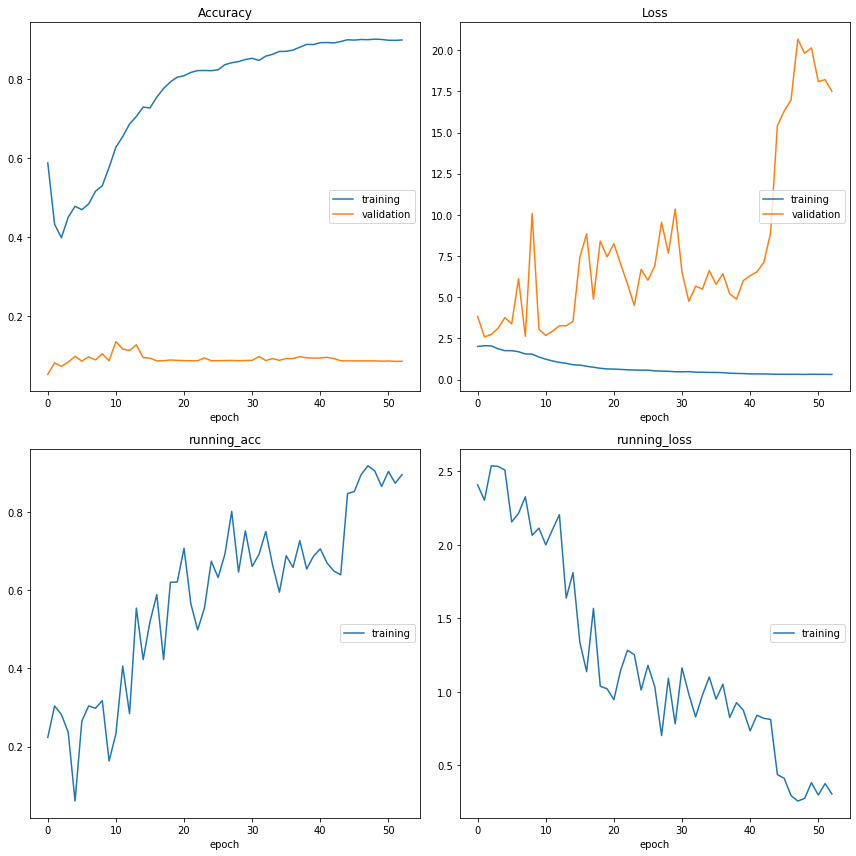

KeyboardInterrupt: 

In [24]:
trial.run(epochs=75)

In [26]:
torch.save(trial.state_dict(), 'alldata_checkpoints/deeperCNN_gating_last_epoch.pth')

# Construct full networks

In [47]:
importlib.reload(cure_models)

<module 'cure_models' from '/home/ubuntu/project/cure_models.py'>

In [69]:
all_data_shallow_gating = cure_models.GroupOfExperts_AllModels_ShallowGating()

In [70]:
all_data_experts = [torch.load(glob.glob(os.path.join('alldata_checkpoints', 'shallowCNN_' + challenge_label + '_all.*.pt'))[0]) for challenge_label in challenge_labels_short.values()]

In [71]:
for i, state in enumerate(all_data_experts):
    all_data_shallow_gating.experts[i].load_state_dict(state['model'], strict=False)

In [72]:
best_data_experts = [None]*13
best_data_experts[0] = torch.load('alldata_checkpoints/shallowCNN_Nochallenge_all.59-0.974.pt')
best_data_experts[1] = torch.load('alldata_checkpoints/shallowCNN_Decolorization_all.74-0.950.pt')
best_data_experts[2] = torch.load('alldata_checkpoints/shallowCNN_Lens blur_all.74-0.771.pt')
best_data_experts[3] = torch.load('alldata_checkpoints/shallowCNN_CodecError_all.67-0.787.pt')
best_data_experts[4] = torch.load('alldata_checkpoints/shallowCNN_Darkening_all.74-0.966.pt')
best_data_experts[5] = torch.load('alldata_checkpoints/shallowCNN_DirtyLens_all.73-0.952.pt')
best_data_experts[6] = torch.load('alldata_checkpoints/shallowCNN_Exposure_all.72-0.751.pt')
best_data_experts[7] = torch.load('alldata_checkpoints/shallowCNN_GaussianBlur_all.74-0.756.pt')
best_data_experts[8] = torch.load('alldata_checkpoints/shallowCNN_Noise_1_3.69-0.852.pt')
best_data_experts[9] = torch.load('alldata_checkpoints/shallowCNN_Rain_1_3.53-0.892.pt')
best_data_experts[10] = torch.load('alldata_checkpoints/shallowCNN_Shadow_all.62-0.974.pt')
best_data_experts[11] = torch.load('alldata_checkpoints/shallowCNN_Snow_all.38-0.902.pt')
best_data_experts[12] = torch.load('alldata_checkpoints/shallowCNN_Haze_all.74-0.885.pt')


In [73]:
best_data_shallow_gating = cure_models.GroupOfExperts_AllModels_ShallowGating()
for i, state in enumerate(best_data_experts):
    best_data_shallow_gating.experts[i].load_state_dict(state['model'], strict=False)

In [74]:
all_data_shallow_gating.gating_network.load_state_dict(
    torch.load('alldata_checkpoints/shallowCNN_gating_network_all_data.04-0.089.pt')['model'], strict=False
)
best_data_shallow_gating.gating_network.load_state_dict(
    torch.load('alldata_checkpoints/shallowCNN_gating_network_all_data.04-0.089.pt')['model'], strict=False
)

<All keys matched successfully>

In [75]:
all_data_deeper_gating = cure_models.GroupOfExperts_AllModels_DeeperGating()
best_data_deeper_gating = cure_models.GroupOfExperts_AllModels_DeeperGating()

for i, state in enumerate(all_data_experts):
    all_data_deeper_gating.experts[i].load_state_dict(state['model'], strict=False)

for i, state in enumerate(best_data_experts):
    best_data_deeper_gating.experts[i].load_state_dict(state['model'], strict=False)
    
all_data_deeper_gating.gating_network.load_state_dict(
    torch.load('alldata_checkpoints/deeperCNN_gating_network_all_data.10-0.136.pt')['model']
)
best_data_deeper_gating.gating_network.load_state_dict(
    torch.load('alldata_checkpoints/deeperCNN_gating_network_all_data.10-0.136.pt')['model']
)

<All keys matched successfully>

In [76]:
clean_expert = cure_models.ShallowNetwork()
clean_expert.load_state_dict(all_data_experts[0]['model'])

<All keys matched successfully>

In [77]:
three_class_GOE = cure_models.GroupOfExpertsShallowNetwork()
three_class_GOE.load_state_dict(
    torch.load('checkpoints/mix_of_experts_raw_gating_state_dict.pt')
)

<All keys matched successfully>

In [78]:
models = [
    all_data_shallow_gating,
    best_data_shallow_gating,
    all_data_deeper_gating,
    best_data_deeper_gating,
    clean_expert,
    three_class_GOE
]

models = [model.cuda() for model in models]

model_labels = [
    'All Data Shallow Gating',
    'Best Data Shallow Gating',
    'All Data Deeper Gating',
    'Best Data Deeper Gating',
    'Clean Expert',
    'Three Class GOE'
]

In [80]:
%%time
# iterate over each challenge type and level

# len 5 vector of model results on clean data
clean_results = []
# outer layer is challenge, inner layer is challenge level, inside of which is a list of results per model
challenge_results = np.zeros((12, 6, 6))

# load clean data for baseline
testdataset = cure_dataset.CURETSRDatasetCached('../data', 'Test', '*', '00', '*', transform=load_raw)
testloader = torch.utils.data.DataLoader(testdataset, batch_size=1000,
                                          shuffle=False, num_workers=0)

clean_results = [cure_utils.model_acc(model, testloader) for model in models]

for idx, challenge in enumerate(list(challenge_labels.keys())[1:]):
    print(idx)
    challenge_results[idx][0] = clean_results
    for challenge_level in range(1,6):
        testdataset = cure_dataset.CURETSRDatasetCached('../data', 'Test', '*', challenge, '0'+str(challenge_level), transform=load_raw)
        testloader = torch.utils.data.DataLoader(testdataset, batch_size=1000,
                                          shuffle=False, num_workers=0)
        challenge_results[idx,challenge_level, :] = np.array([cure_utils.model_acc(model, testloader) for model in models])
        


0
1
2
3
4
5
6
7
8
9
10
11
CPU times: user 9min 53s, sys: 1min 48s, total: 11min 42s
Wall time: 11min 42s


In [61]:
importlib.reload(cure_utils)

<module 'cure_utils' from '/home/ubuntu/project/cure_utils.py'>

In [82]:
torch.save(challenge_results, 'all_GOE_results.pth')

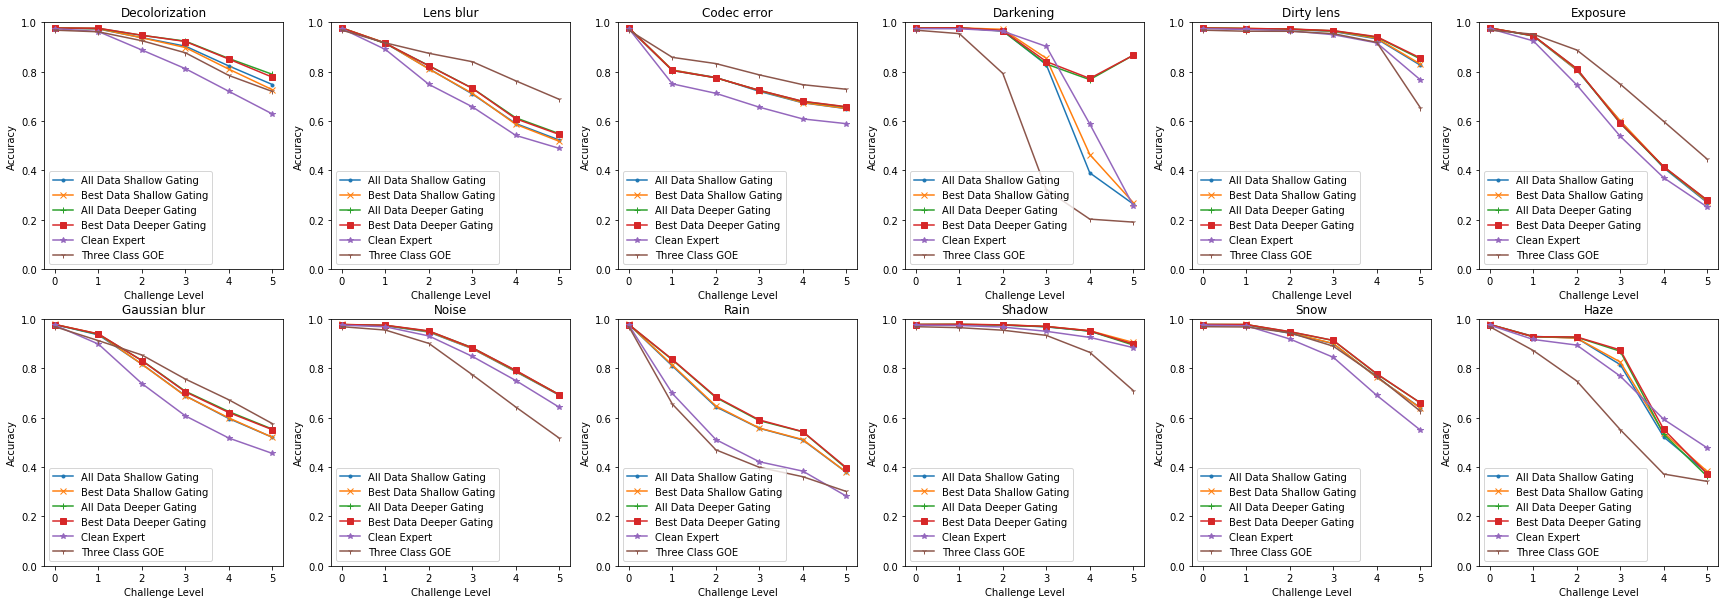

In [81]:
markers=['.','x','+','s','*', '1']
plt.subplots(2,6, figsize=(30,10))
for challenge_idx, challenge_label in enumerate(list(challenge_labels.values())[1:]):
    plt.subplot(2,6,challenge_idx+1)
    plt.title(challenge_label)
    plt.xlabel('Challenge Level')
    plt.ylabel('Accuracy')
    plt.ylim(0,1)
    for model_idx, model_label in enumerate(model_labels):
        plt.plot(np.arange(6), challenge_results[challenge_idx, :, model_idx], marker=markers[model_idx], label=model_label)
    plt.legend()

# More Graphs

In [92]:
models = [
    clean_expert,
    best_data_shallow_gating,
    best_data_deeper_gating,
    three_class_GOE
]

models = [model.cuda() for model in models]

model_labels = [
    'Baseline Classifier',
    'Group of Experts',
    'Group of Experts (Deep Gating)',
    'Group of Experts (Three Class)'
]

In [4]:
model_labels = [
    'Baseline Classifier',
    'Group of Experts',
    'Group of Experts (Deep Gating)',
    'Group of Experts (Three Class)'
]



In [89]:
%%time
# iterate over each challenge type and level

# len 5 vector of model results on clean data
clean_results = []
# outer layer is challenge, inner layer is challenge level, inside of which is a list of results per model
challenge_results = np.zeros((12, 6, 5))

# load clean data for baseline
testdataset = cure_dataset.CURETSRDatasetCached('../data', 'Test', '*', '00', '*', transform=load_raw)
testloader = torch.utils.data.DataLoader(testdataset, batch_size=1000,
                                          shuffle=False, num_workers=0)

clean_results = [cure_utils.model_acc(model, testloader) for model in models]

for idx, challenge in enumerate(list(challenge_labels.keys())[1:]):
    challenge_results[idx,0, :] = np.array(clean_results + [cure_utils.model_acc(best_data_shallow_gating.experts[idx+1], testloader)])

for idx, challenge in enumerate(list(challenge_labels.keys())[1:]):
    print(idx)
#     challenge_results[idx,0, :] = np.array(clean_results + [cure_utils.model_acc(best_shallow_gating.expert[idx], testloader)])
    for challenge_level in range(1,6):
        testdataset = cure_dataset.CURETSRDatasetCached('../data', 'Test', '*', challenge, '0'+str(challenge_level), transform=load_raw)
        testloader = torch.utils.data.DataLoader(testdataset, batch_size=1000,
                                          shuffle=False, num_workers=0)
        challenge_results[idx,challenge_level, :] = np.array([cure_utils.model_acc(model, testloader) for model in models] + [cure_utils.model_acc(best_data_shallow_gating.experts[idx+1], testloader)])
        


0
1
2
3
4
5
6
7
8
9
10
11
CPU times: user 7min 21s, sys: 1min 9s, total: 8min 31s
Wall time: 8min 30s


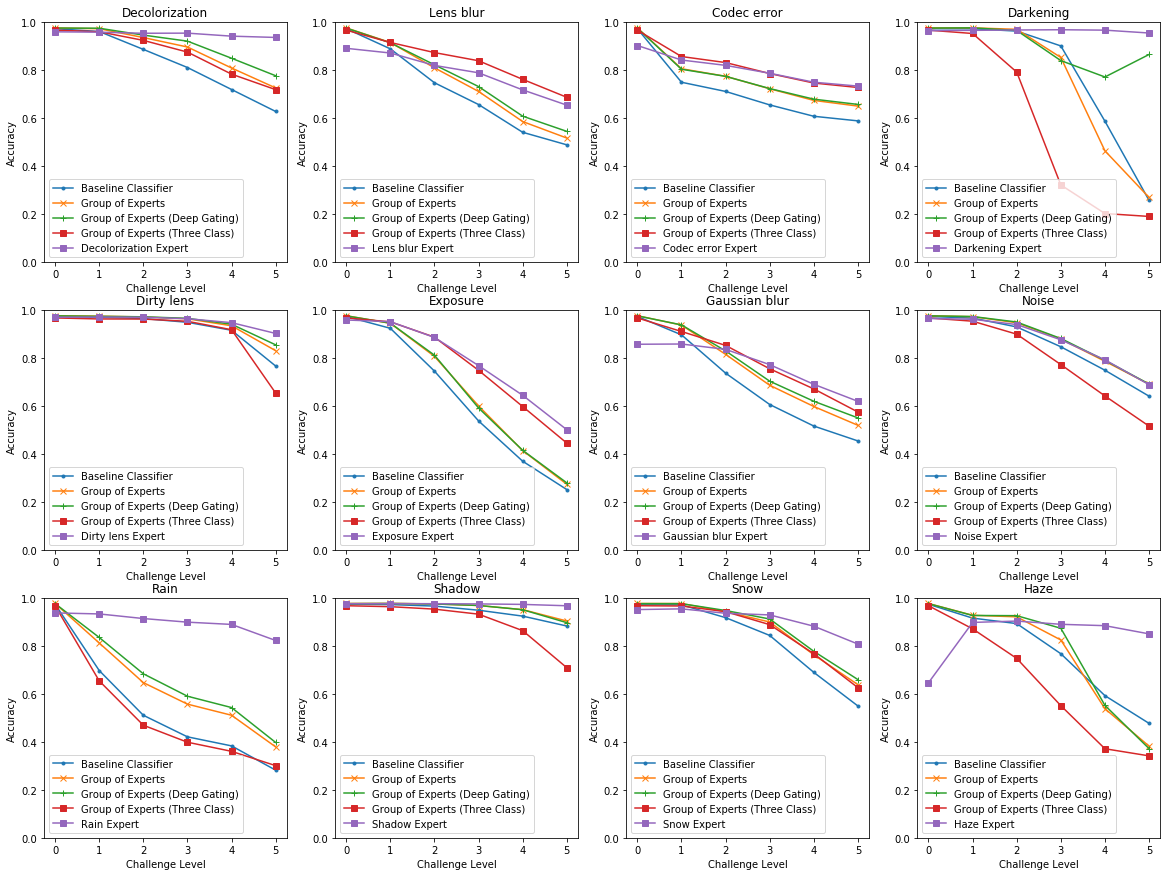

In [7]:
markers=['.','x','+','s','*', '1']
plt.subplots(3,4, figsize=(20,15))
for challenge_idx, challenge_label in enumerate(list(challenge_labels.values())[1:]):
    plt.subplot(3,4,challenge_idx+1)
    plt.title(challenge_label)
    plt.xlabel('Challenge Level')
    plt.ylabel('Accuracy')
    plt.ylim(0,1)
    for model_idx, model_label in enumerate(model_labels):
        plt.plot(np.arange(6), challenge_results[challenge_idx, :, model_idx], marker=markers[model_idx], label=model_label)
    plt.plot(np.arange(6), challenge_results[challenge_idx, :, len(model_labels)], marker=markers[model_idx], label="{} Expert".format(challenge_label))
    plt.legend()

In [94]:
model_labels

['Baseline Classifier',
 'Group of Experts',
 'Group of Experts (Deep Gating)',
 'Group of Experts (Three Class)']

In [96]:
torch.save(challenge_results, 'final_results_data.pth')

In [2]:
challenge_results = torch.load('final_results_data.pth')